Importing Libraries

In [4]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

# import warnings
import warnings
# filter warnings
warnings.filterwarnings('ignore')

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os, logging
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
logging.getLogger("tensorflow").setLevel(logging.CRITICAL)

for dirname, _, filenames in os.walk('/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


Reading CSV File (Dataset)

In [5]:
data = pd.read_csv("age_gender.csv")
print(data.shape)
data.head()

(23705, 5)


,age,ethnicity,gender,img_name,pixels
0,1,2,0,20161219203650636.jpg.chip.jpg,129 128 128 126 127 130 133 135 139 142 145 14...
1,1,2,0,20161219222752047.jpg.chip.jpg,164 74 111 168 169 171 175 182 184 188 193 199...
2,1,2,0,20161219222832191.jpg.chip.jpg,67 70 71 70 69 67 70 79 90 103 116 132 145 155...
3,1,2,0,20161220144911423.jpg.chip.jpg,193 197 198 200 199 200 202 203 204 205 208 21...
4,1,2,0,20161220144914327.jpg.chip.jpg,202 205 209 210 209 209 210 211 212 214 218 21...


Cleaning Data

In [6]:
data = data.drop("img_name", axis=1)

In [7]:
data.isnull().sum()

age          0
ethnicity    0
gender       0
pixels       0
dtype: int64

In [8]:
columns = ["age","gender","ethnicity"]
y = data.drop("pixels", axis = 1)
x = data.drop(columns, axis = 1)

In [9]:
x.head()

,pixels
0,129 128 128 126 127 130 133 135 139 142 145 14...
1,164 74 111 168 169 171 175 182 184 188 193 199...
2,67 70 71 70 69 67 70 79 90 103 116 132 145 155...
3,193 197 198 200 199 200 202 203 204 205 208 21...
4,202 205 209 210 209 209 210 211 212 214 218 21...


In [10]:
y.head()

,age,ethnicity,gender
0,1,2,0
1,1,2,0
2,1,2,0
3,1,2,0
4,1,2,0


In [11]:
y.nunique()

age          104
ethnicity      5
gender         2
dtype: int64

Text(0.5, 1.0, 'Number of age')

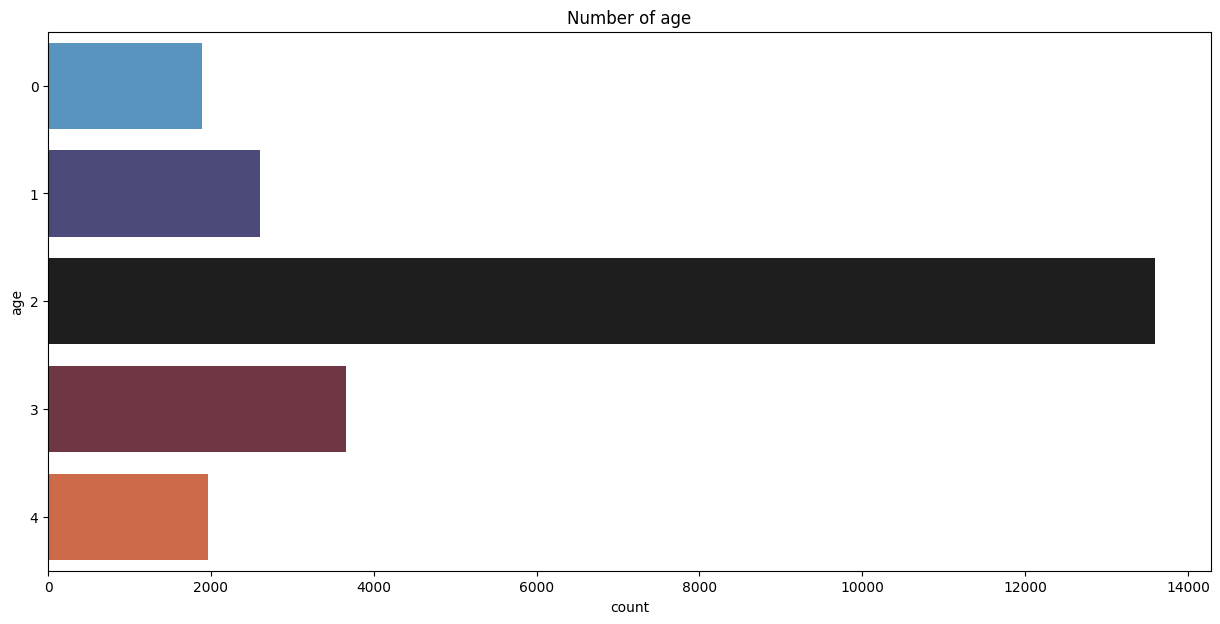

In [12]:
y["age"] = pd.cut(y["age"],bins=[0,3,18,45,64,116],labels=["0","1","2","3","4"])
plt.figure(figsize=(15,7))
g = sns.countplot(y["age"], palette="icefire")
plt.title("Number of age")

Image Shape

In [13]:
num_pixels = len(x['pixels'][0].split(" "))
img_height = int(np.sqrt(len(x['pixels'][0].split(" "))))
img_width = int(np.sqrt(len(x['pixels'][0].split(" "))))
print(num_pixels, img_height, img_width)

2304 48 48


Data Reshaping

In [14]:
x = pd.Series(x["pixels"])
x = x.apply(lambda x: x.split(' '))
x = x.apply(lambda x: np.array(list(map(lambda z: int(z), x))))
x = np.array(x)
x = np.stack(np.array(x), axis=0)
x = np.reshape(x, (-1, 48, 48))

# reshape data
x = x.reshape(-1,48,48,1)
print("x shape: ",x.shape)

x shape:  (23705, 48, 48, 1)


Image Overview

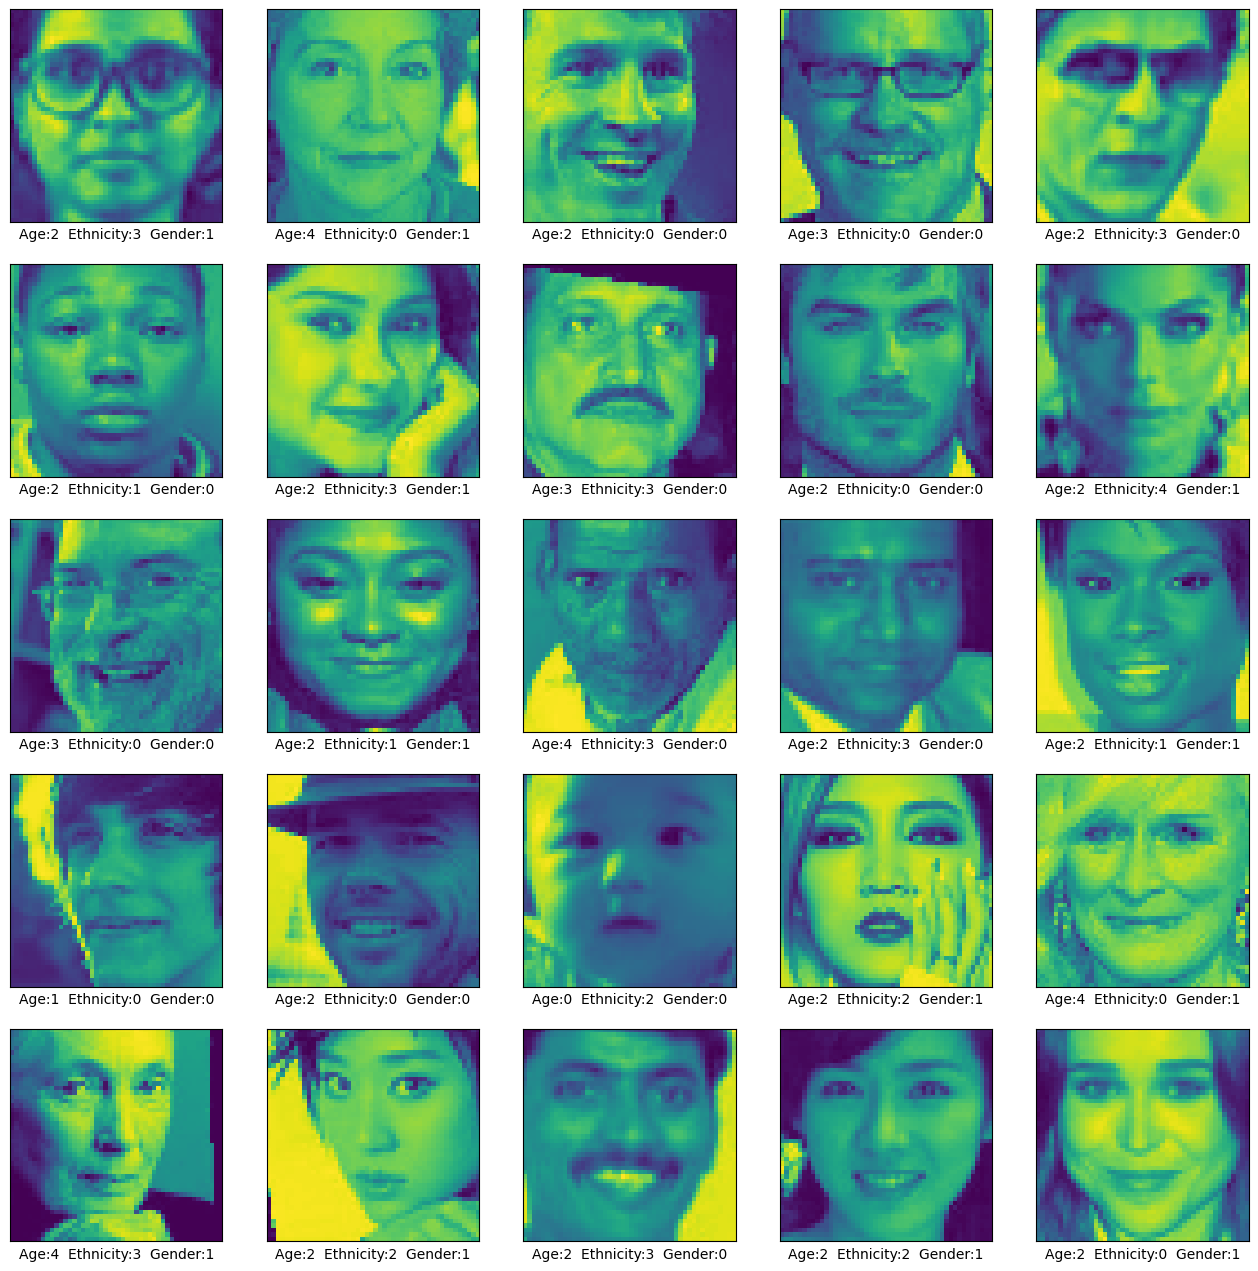

In [15]:
plt.figure(figsize=(16,16))
for i,a in zip(np.random.randint(0, 23705, 25),range(1,26)):
    plt.subplot(5,5,a)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x[i])
    plt.xlabel(
        "Age:"+str(y['age'].iloc[i])+
        "  Ethnicity:"+str(y['ethnicity'].iloc[i])+
        "  Gender:"+ str(y['gender'].iloc[i])
    )
plt.show()

Importing Libraries

In [16]:
from sklearn.metrics import confusion_matrix
import itertools
import tensorflow as tf
import plotly.express as px
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical # convert to one-hot-encoding
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, InputLayer
from tensorflow.keras.optimizers import RMSprop,Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.losses import BinaryCrossentropy, SparseCategoricalCrossentropy

Categorizing Targe Values

In [17]:
age_matrix = np.array(y["age"]) 
gender_matrix = np.array(y["gender"])
ethnicity_matrix = np.array(y["ethnicity"])
age = to_categorical(age_matrix, num_classes = 5)
gender = to_categorical(y["gender"], num_classes = 2)
ethnicity = to_categorical(ethnicity_matrix, num_classes = 5)
print(age, gender, ethnicity)

[[1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]] [[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]] [[0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 ...
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0.]]


Normalizing the data

In [18]:
x = x / 255.0
x = x / 255.0

Image Data Generator

In [19]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # dimesion reduction
        rotation_range=5,  # randomly rotate images in the range 5 degrees
        zoom_range = 0.1, # Randomly zoom image 10%
        width_shift_range=0.1,  # randomly shift images horizontally 10%
        height_shift_range=0.1,  # randomly shift images vertically 10%
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(x)

Train Test Split

In [20]:
from sklearn.model_selection import train_test_split
X_train_ethnicity, X_test_ethnicity, y_train_ethnicity, y_test_ethnicity = train_test_split(x, ethnicity, test_size= 0.3)
X_train_gender, X_test_gender, y_train_gender, y_test_gender = train_test_split(x, gender, test_size= 0.3)
X_train_age, X_test_age, y_train_age, y_test_age = train_test_split(x, age, test_size= 0.3)

Building Model

In [21]:
def my_model(num_classes, activation, loss):
    model = Sequential() 
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding = "same", input_shape=(48,48,1)))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding = "same"))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding = "same"))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation= activation))
    model.compile(optimizer='Adam',
              loss= loss,
              metrics=['accuracy'])
    return model

In [22]:
early_stopping = EarlyStopping(patience=10, min_delta=0.001,restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience=3, verbose=1, factor=0.5, min_lr=0.00001)

Ethnicity Prediction

In [23]:
epochs = 200  # for better result increase the epochs
batch_size = 64
model_ethnicity = my_model(5,"softmax",'categorical_crossentropy')
history_ethnicity = model_ethnicity.fit(X_train_ethnicity, y_train_ethnicity, batch_size=batch_size, epochs = epochs, validation_data = (X_test_ethnicity,y_test_ethnicity), steps_per_epoch= X_train_ethnicity.shape[0] // batch_size, callbacks= [early_stopping, learning_rate_reduction])

Epoch 1/200
259/259 [==============================] - 43s 154ms/step - loss: 1.0631 - accuracy: 0.6068 - val_loss: 1.4713 - val_accuracy: 0.4283 - lr: 0.0010
Epoch 2/200
259/259 [==============================] - 38s 147ms/step - loss: 0.8029 - accuracy: 0.7160 - val_loss: 1.4145 - val_accuracy: 0.5470 - lr: 0.0010
Epoch 3/200
259/259 [==============================] - 36s 138ms/step - loss: 0.7124 - accuracy: 0.7506 - val_loss: 1.5289 - val_accuracy: 0.5089 - lr: 0.0010
Epoch 4/200
259/259 [==============================] - 36s 139ms/step - loss: 0.6530 - accuracy: 0.7722 - val_loss: 1.8647 - val_accuracy: 0.1976 - lr: 0.0010
Epoch 5/200
259/259 [==============================] - 38s 145ms/step - loss: 0.6013 - accuracy: 0.7889 - val_loss: 8.0701 - val_accuracy: 0.1887 - lr: 0.0010
Epoch 6/200
259/259 [==============================] - 38s 145ms/step - loss: 0.5525 - accuracy: 0.8071 - val_loss: 3.8933 - val_accuracy: 0.2040 - lr: 0.0010
Epoch 7/200
259/259 [=========================

In [24]:
fig = px.line(
    history_ethnicity.history, y=['loss', 'val_loss'],
    labels={'index': 'epoch', 'value': 'loss'}, 
    title='Training History')
fig.show()

In [25]:
loss, acc = model_ethnicity.evaluate(X_test_ethnicity, y_test_ethnicity, verbose=0)
print('Test loss: {}'.format(loss))
print('Test Accuracy: {}'.format(acc))

Test loss: 1.4145019054412842
Test Accuracy: 0.5469628572463989


Age Prediction

In [26]:
model_age = my_model(5,"softmax",'categorical_crossentropy')
history_age = model_age.fit(X_train_age, y_train_age, batch_size=batch_size, epochs = epochs, validation_data = (X_test_age,y_test_age), steps_per_epoch= X_train_age.shape[0] // batch_size, callbacks= [early_stopping, learning_rate_reduction])

Epoch 1/200
259/259 [==============================] - 56s 189ms/step - loss: 0.9096 - accuracy: 0.6622 - val_loss: 1.6174 - val_accuracy: 0.0837 - lr: 0.0010
Epoch 2/200
259/259 [==============================] - 61s 238ms/step - loss: 0.6881 - accuracy: 0.7353 - val_loss: 3.0929 - val_accuracy: 0.0837 - lr: 0.0010
Epoch 3/200
259/259 [==============================] - 66s 253ms/step - loss: 0.6191 - accuracy: 0.7622 - val_loss: 6.0350 - val_accuracy: 0.5651 - lr: 0.0010
Epoch 4/200
259/259 [==============================] - 69s 266ms/step - loss: 0.5711 - accuracy: 0.7806 - val_loss: 2.8702 - val_accuracy: 0.5647 - lr: 0.0010
Epoch 5/200
259/259 [==============================] - 70s 272ms/step - loss: 0.5307 - accuracy: 0.7896 - val_loss: 8.5830 - val_accuracy: 0.5651 - lr: 0.0010
Epoch 6/200
259/259 [==============================] - 61s 236ms/step - loss: 0.4868 - accuracy: 0.8066 - val_loss: 10.7662 - val_accuracy: 0.5651 - lr: 0.0010
Epoch 7/200
259/259 [========================

In [27]:
fig = px.line(
    history_age.history, y=['loss', 'val_loss'],
    labels={'index': 'epoch', 'value': 'loss'}, 
    title='Training History')
fig.show()

In [28]:
loss, acc = model_age.evaluate(X_test_age, y_test_age, verbose=0)
print('Test loss: {}'.format(loss))
print('Test Accuracy: {}'.format(acc))

Test loss: 1.6174014806747437
Test Accuracy: 0.08366141468286514


Gender Prediction

In [29]:
model_gender = my_model(2, "sigmoid", "binary_crossentropy")
history_gender = model_gender.fit(X_train_gender, y_train_gender, batch_size=batch_size,
                              epochs = epochs, validation_data = (X_test_gender,y_test_gender), steps_per_epoch= X_train_gender.shape[0] // batch_size, callbacks= [early_stopping, learning_rate_reduction])

Epoch 1/200
259/259 [==============================] - 80s 292ms/step - loss: 0.4332 - accuracy: 0.7963 - val_loss: 0.6895 - val_accuracy: 0.5257 - lr: 0.0010
Epoch 2/200
259/259 [==============================] - 75s 290ms/step - loss: 0.3037 - accuracy: 0.8691 - val_loss: 0.6870 - val_accuracy: 0.4835 - lr: 0.0010
Epoch 3/200
259/259 [==============================] - 73s 283ms/step - loss: 0.2642 - accuracy: 0.8871 - val_loss: 1.8612 - val_accuracy: 0.5257 - lr: 0.0010
Epoch 4/200
259/259 [==============================] - 68s 263ms/step - loss: 0.2371 - accuracy: 0.9012 - val_loss: 0.7125 - val_accuracy: 0.4999 - lr: 0.0010
Epoch 5/200
259/259 [==============================] - 53s 204ms/step - loss: 0.2165 - accuracy: 0.9091 - val_loss: 0.6542 - val_accuracy: 0.6055 - lr: 0.0010
Epoch 6/200
259/259 [==============================] - 61s 235ms/step - loss: 0.2025 - accuracy: 0.9154 - val_loss: 2.0849 - val_accuracy: 0.4788 - lr: 0.0010
Epoch 7/200
259/259 [=========================

In [30]:
fig = px.line(
    history_gender.history, y=['loss', 'val_loss'],
    labels={'index': 'epoch', 'value': 'loss'}, 
    title='Training History')
fig.show()

In [31]:
loss, acc = model_gender.evaluate(X_test_gender, y_test_gender, verbose=0)
print('Test loss: {}'.format(loss))
print('Test Accuracy: {}'.format(acc))

Test loss: 0.6542159914970398
Test Accuracy: 0.6054555773735046
